In [1]:
# download of the libraries
!pip install graphviz
!pip install nltk
!pip install stanza
!pip install transformers
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=a2ce12f002c58336c4f0eb31c031885761d80ec6f8c6c7bee6660e225286525b
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# import of the libraries
import numpy as np
import os
import os.path as osp

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph
import stanza

from graphviz import Source

from transformers import AutoTokenizer, BertModel
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter
from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, Dropout

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

import re

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# initialization of the stanza pipeline to get dependency graphs
stanza.download("en")
nlp = stanza.Pipeline('en')

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
# the sentence below is parsed so that a dependency graph is built in the
# following way:
# the word with head index equal to 0 is the main verb
# the words pointing to the verb are either complements or 
# verbs form coordinate or subordinate sentences
# or even the subject
example_sentence = nlp("I like big graphs and I cannot lie")
to_print = [f"id: {word.id}\tword: {word.text}\t\t head id: {word.head}" for sentence in example_sentence.sentences for word in sentence.words]
for elem in to_print:
  print(elem)

id: 1	word: I		 head id: 2
id: 2	word: like		 head id: 0
id: 3	word: big		 head id: 4
id: 4	word: graphs		 head id: 2
id: 5	word: and		 head id: 8
id: 6	word: I		 head id: 8
id: 7	word: cannot		 head id: 8
id: 8	word: lie		 head id: 2


In [4]:
# function for the construction of the dictionary containing tokens and
# dependencies
def get_tokens_and_dependencies(to_tokenize):
  nlp_dep = nlp(to_tokenize)
  to_return = {}
  for idx, sentence in enumerate(nlp_dep.sentences):
    #token_list = np.array(["[CLS]"]) instead of this it is better to add the pooler output as node 0
    token_list = np.array([])
    heads_arr = np.array([0], dtype=np.int32)
    for word in sentence.words:
      token_list = np.append(token_list, word.text)
      heads_arr = np.append(heads_arr, word.head) 
    starting_nodes = np.arange(0, heads_arr.shape[0])
    dependency_arr = np.vstack((starting_nodes, heads_arr))
    to_return.update({f"{idx} tokens": token_list, f"{idx} dependency":dependency_arr})
  return to_return

In [5]:
# output example
returned_dict = get_tokens_and_dependencies("My babe don't stand no cheating, of course she will believe me. Oh yes, she don't stand no cheating")
print(returned_dict["0 tokens"])
print(returned_dict["0 dependency"])
print(returned_dict["1 tokens"])
print(returned_dict["1 dependency"])

['My' 'babe' 'do' "n't" 'stand' 'no' 'cheating' ',' 'of' 'course' 'she'
 'will' 'believe' 'me' '.']
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  2  5  5  5  0  7  5  5 13  9 13 13  5 13  5]]
['Oh' 'yes' ',' 'she' 'do' "n't" 'stand' 'no' 'cheating']
[[0 1 2 3 4 5 6 7 8 9]
 [0 7 7 2 7 7 7 0 9 7]]


In [5]:
# initialization of the tokenizer and the bert model
# to compute the embeddings for each token
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# example of usage
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = bert_model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [ ]:
print(inputs)
print(outputs.last_hidden_state.shape)
print(outputs.last_hidden_state[0, 1, :].shape)
print(outputs.pooler_output.shape)

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 8, 768])
torch.Size([768])
torch.Size([1, 768])


In [ ]:
# we are actually converting stanza tokens to bert ids
maybe = tokenizer.convert_tokens_to_ids(returned_dict["0 tokens"])
print(torch.tensor(maybe))

tensor([  101,   100, 11561,  2079,   100,  3233,  2053, 16789,  1010,  1997,
         2607,  2016,  2097,  2903,  2033,  1012])


In [6]:
# given a list of tokens, this function returns a dictionary where
# the corresponding input_ids, token_type_ids and attention mask are stored
def get_bert_input_from_tokens(token_list):
  ids = np.array(tokenizer.convert_tokens_to_ids(token_list))
  input_ids = torch.tensor(ids.reshape(1, ids.shape[0]), dtype = torch.int32)
  len_tens = input_ids.shape[1]
  token_type_ids = torch.tensor(np.zeros(len_tens, dtype = int).reshape(1, len_tens), dtype = torch.int32)
  attn_mask = torch.tensor(np.ones(len_tens, dtype = int).reshape(1, len_tens), dtype = torch.int32)
  to_return = {"input_ids":input_ids, "token_type_ids":token_type_ids, "attention_mask":attn_mask}
  return to_return

In [ ]:
sentence = returned_dict["0 tokens"]
print(len(sentence))
to_pass_to_bert = get_bert_input_from_tokens(sentence)
print(to_pass_to_bert)
# the ** notation is used in order to pass the elements of the
# dictionary as a variable number of arguments to the BERT model
obt_outputs = bert_model(**to_pass_to_bert)

print(obt_outputs.last_hidden_state.shape)

16
{'input_ids': tensor([[  101,   100, 11561,  2079,   100,  3233,  2053, 16789,  1010,  1997,
          2607,  2016,  2097,  2903,  2033,  1012]], dtype=torch.int32), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)}
torch.Size([1, 16, 768])


In [7]:
# testing of the private method of the custom torch_geometric dataset that
# we are about to create.
# The objective of this method is to take a sentence and its ground truth label
# and convert it into a graph data object that has:
# 1. bert embedding as node features
# 2. stanza dependency links as links
# 3. the associated ground truth label
def __build_graph_Data__(sentence, y_val):  
    tok_dep_dict = get_tokens_and_dependencies(sentence)
    intra_sentence_data_list = []
    if len(tok_dep_dict.keys()) > 0:
      for i in range(0, len(tok_dep_dict.keys()) // 2):
        bert_input = get_bert_input_from_tokens(tok_dep_dict[f"{i} tokens"])
        bert_output = bert_model(**bert_input)
        bert_output_states = bert_output.last_hidden_state[0, :, :].clone().detach().requires_grad_()
        bert_pooler_output = bert_output.pooler_output[0, :].clone().detach().requires_grad_()
        # the sentence is modelled as the directed dependency graph where the nodes
        # have the bert embeddings as features, since the verb of the main
        # sentence points to 0, node 0 has the pooler output as its features,
        # as they represent the meaning of the whole sentence 
        node_features = torch.vstack((bert_pooler_output, bert_output_states)) 
        edge_idxs = torch.tensor(tok_dep_dict[f"{i} dependency"], dtype = torch.float32)
        data = Data(x = node_features, edge_index = edge_idxs, y = y_val)
        intra_sentence_data_list.append(data)
      dl = DataLoader(intra_sentence_data_list, len(intra_sentence_data_list), shuffle = False)
      # porcata micidiale
      for batch in dl:
        return batch
    else:
      return None

In [32]:
single_long_sentence = "My babe don't stand no cheating, of course she will believe me. Oh yes, she don't stand no cheating"
g_data = __build_graph_Data__(single_long_sentence, 8)
print(g_data.y)
print(g_data.edge_index.shape)

tensor([8, 8])
torch.Size([2, 26])


In [8]:
# the dataset that we are considering can be found here:
# https://www.kaggle.com/code/harshpriye/covid-tweets-sentiment-analysis

df=pd.read_csv("/content/Corona_NLP_train.csv", encoding='latin1')
df.head

<bound method NDFrame.head of        UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrb

In [ ]:
df.shape

(41157, 6)

In [ ]:
# checking for null values
overview=pd.concat([df.isnull().sum(),df.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,41157
ScreenName,0,41157
Location,8590,12220
TweetAt,0,30
OriginalTweet,0,41157
Sentiment,0,5


In [9]:
# Removing NULLS:
idx=df.loc[df.Location.isnull()].index
df_clean=df.drop(idx)
df_clean.shape

(32567, 6)

In [ ]:
overview=pd.concat([df_clean.isnull().sum(),df_clean.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,32567
ScreenName,0,32567
Location,0,12220
TweetAt,0,30
OriginalTweet,0,32567
Sentiment,0,5


In [10]:
df.drop(columns=['UserName','ScreenName','Location','TweetAt'], inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
sentiments=df.Sentiment.value_counts()
sentiments

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

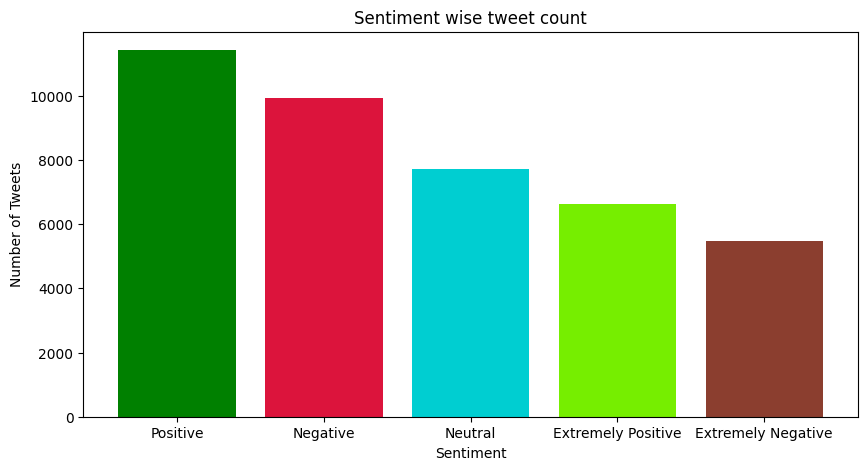

In [ ]:
plt.subplots(figsize=(10,5))
plt.bar(sentiments.index,sentiments.values, color=['green','#DC143C','#00CED1','#76EE00','#8B3E2F'])
plt.title("Sentiment wise tweet count")
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

<ipython-input-17-0e1d46418139>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
<ipython-input-17-0e1d46418139>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_lengths)


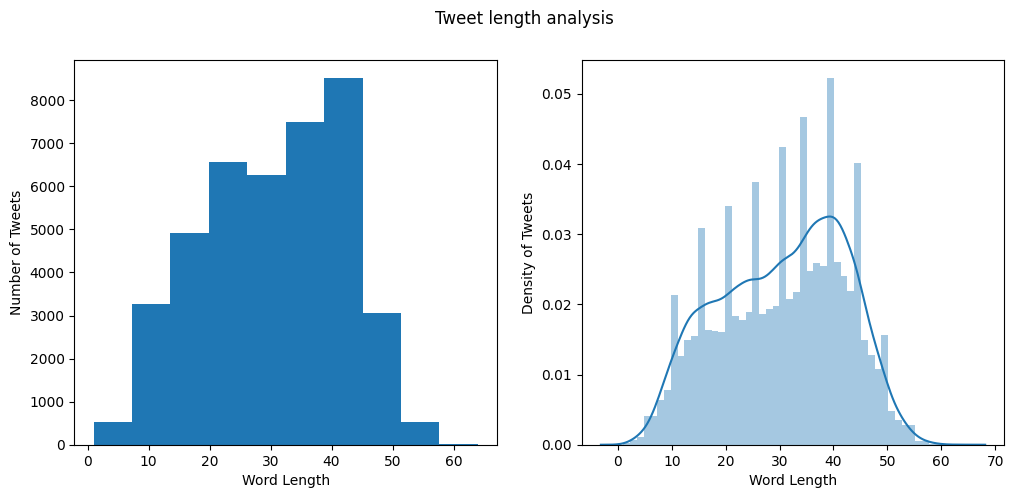

In [ ]:
tweet_lengths = df['OriginalTweet'].apply(lambda x: len(x.split()))

plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(tweet_lengths)
plt.suptitle("Tweet length analysis")
plt.xlabel("Word Length")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.distplot(tweet_lengths)
plt.xlabel("Word Length")
plt.ylabel("Density of Tweets")
plt.show()

In [11]:
# tweet cleaning
# tweets with a low number of tokens should be eliminated

def preprocessing(x):
    # helper functions:
    def remove_hashtags(text): return re.sub(r'#\w*', ' ' , text)
    def remove_mentions(text): return re.sub(r'@\w*', ' ' , text)
    def remove_urls(text): return re.sub(r'https?://\S+', ' ', text)
    def remove_apostrophe(text): return re.sub(r"'s\b", "", text)
    def remove_special_chars(text): return re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    def remove_numbers(text): return re.sub(r'[\d]', ' ', text)
    def remove_formatting_symbols(text): return re.sub(r"[\r\n]+",'',text)
    def remove_escape_characters(text): return re.sub(r"\\",'',text)
    def remove_extra_spaces(text): return re.sub(r"\s{2,}",' ',text)
    x=x.apply(remove_hashtags)
    x=x.apply(remove_mentions)
    x=x.apply(remove_urls)
    x=x.apply(remove_apostrophe)
    x=x.apply(remove_special_chars)
    x=x.apply(remove_numbers)
    x=x.apply(remove_formatting_symbols)
    x=x.apply(remove_escape_characters)
    x=x.apply(remove_extra_spaces)
    x=x.str.lower()
    return x

In [20]:
%%time
df['OriginalTweet']=preprocessing(df['OriginalTweet'])
df

CPU times: user 1.43 s, sys: 17.3 ms, total: 1.45 s
Wall time: 1.54 s


,OriginalTweet,Sentiment
0,and and,2
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,me ready to go at supermarket during the outbr...,0
...,...,...
41152,airline pilots offering to stock supermarket s...,2
41153,response to complaint not provided citing covi...,0
41154,you know it s getting tough when is rationing ...,3
41155,is it wrong that the smell of hand sanitizer i...,2


In [ ]:
# checking random tweet:
df.iloc[41153,0]

'response to complaint not provided citing covid related delays yet prompt in rejecting policy before consumer tat is over way to go '

In [14]:
# function to build sentiment wisewordcloud:
def show_wordcloud(df):
    sentiments=df.Sentiment.value_counts().index.to_list()
    
    stopwords = set(STOPWORDS)
    
    plt.subplots(figsize=(14,14))
    i=1
    for senti in sentiments:
        curr=df['OriginalTweet'].loc[df.Sentiment==senti]
        text=curr.values
        text=' '.join(text)
        
        wordcloud=WordCloud(max_words=100, stopwords=stopwords, background_color='white', max_font_size=50).generate(text)
        
        plt.subplot(3,2,i)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(senti,fontsize=15)
        i+=1

<ipython-input-14-2de648a3933a>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)


CPU times: user 5.75 s, sys: 278 ms, total: 6.02 s
Wall time: 8.96 s


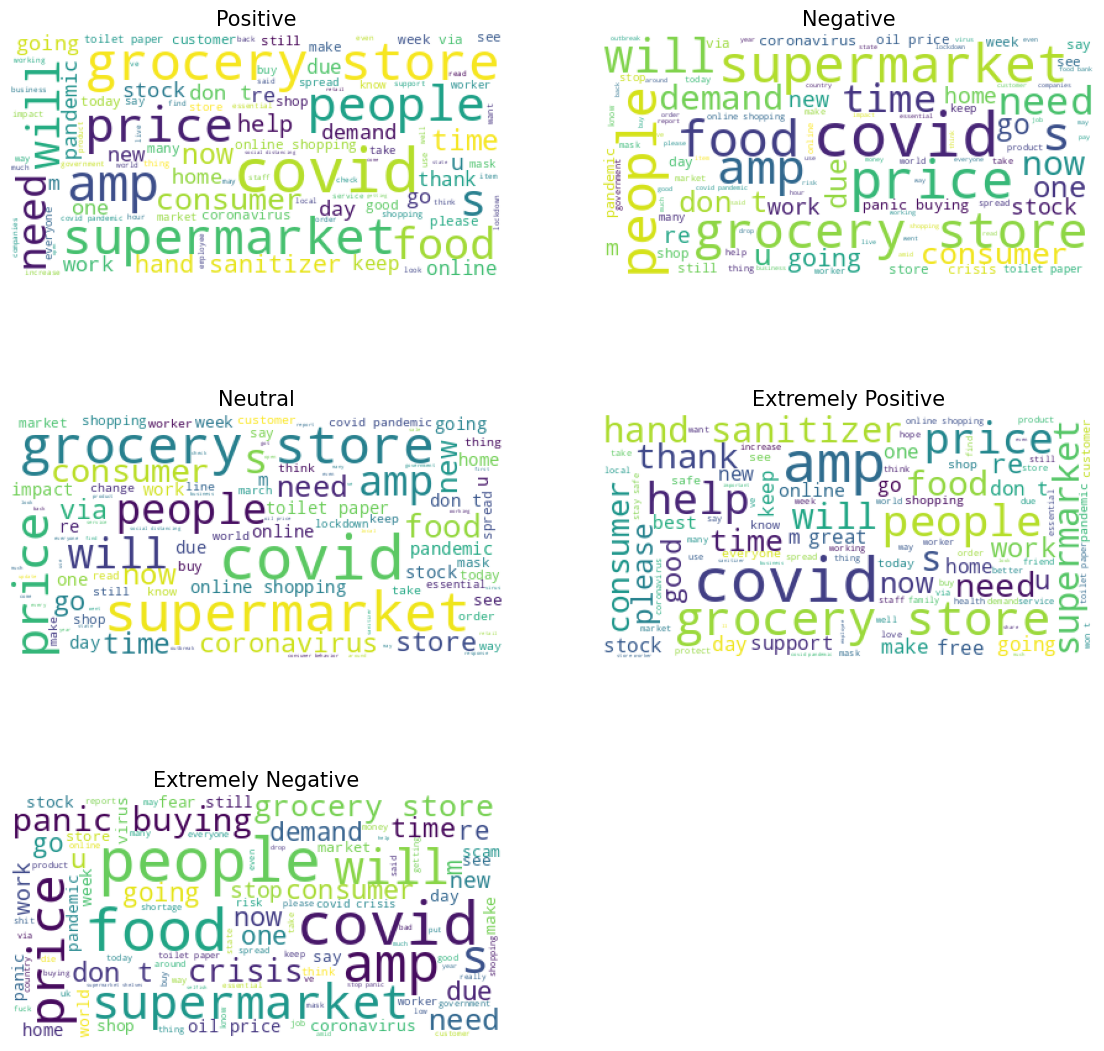

In [15]:
%%time
# generating wordclouds:
show_wordcloud(df)

In [12]:
# function for label reduction and encoding:
def label_preprocessing(labels):
    lab_dict={
        'Extremely Negative': 0,
        'Negative': 1,
        'Neutral': 2,
        'Positive': 3,
        'Extremely Positive': 4
    }
    labels=labels.map(lab_dict)
    
    return labels

In [13]:
%%time
# label preprocessing:
df['Sentiment']=label_preprocessing(df['Sentiment'])
df

CPU times: user 11.5 ms, sys: 460 µs, total: 12 ms
Wall time: 19.2 ms


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,3
2,Coronavirus Australia: Woolworths to give elde...,3
3,My food stock is not the only one which is emp...,3
4,"Me, ready to go at supermarket during the #COV...",0
...,...,...
41152,Airline pilots offering to stock supermarket s...,2
41153,Response to complaint not provided citing COVI...,0
41154,You know itÂs getting tough when @KameronWild...,3
41155,Is it wrong that the smell of hand sanitizer i...,2


In [ ]:
senti=df['Sentiment'].value_counts()
senti

3    11422
1     9917
2     7713
4     6624
0     5481
Name: Sentiment, dtype: int64

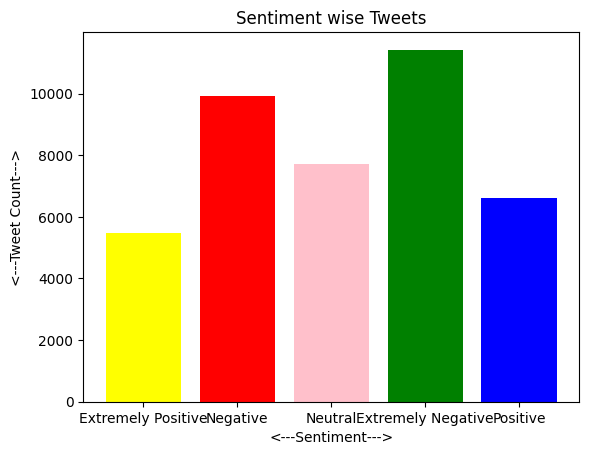

In [ ]:
# this must be plotted correctly, it is all wrong
plt.bar(senti.index, senti.values, color=['green','red','pink', 'blue', 'yellow'])
plt.xticks(senti.index, ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title('Sentiment wise Tweets')
plt.xlabel('<---Sentiment--->')
plt.ylabel('<---Tweet Count--->')
plt.show()

In [21]:
df_to_use = df.iloc[:20]
df_to_use

,OriginalTweet,Sentiment
0,and and,2
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,me ready to go at supermarket during the outbr...,0
5,as news of the region s first confirmed covid ...,3
6,cashier at grocery store was sharing his insig...,3
7,was at the supermarket today didn t buy toilet...,2
8,due to covid our retail store and classroom in...,3
9,for corona prevention we should stop to buy th...,1


In [22]:
df_to_use_tweet_list = df_to_use["OriginalTweet"]
tweet_list = df_to_use_tweet_list.to_list()


df_to_use_sentiments = df_to_use["Sentiment"]
sentiment_list = df_to_use_sentiments.to_list()

for index in range(0, len(tweet_list)):
  if tweet_list[index] == "":
    del tweet_list[index]
    del sentiment_list[index]

train_idx = int(len(tweet_list)*80 // 100) 

tweet_list_train = tweet_list[:train_idx]
tweet_list_val = tweet_list[train_idx:]
sentiment_list_train = sentiment_list[:train_idx]
sentiment_list_val = sentiment_list[train_idx:]

print(tweet_list_train[0])
print(sentiment_list_train[0])

 and and 
2


In [23]:
print(np.unique(sentiment_list_train, return_counts = True))
print(np.unique(sentiment_list_val, return_counts = True))

(array([0, 1, 2, 3, 4]), array([1, 1, 3, 9, 2]))
(array([2, 3, 4]), array([2, 1, 1]))


In [14]:
# class containing the graph data that must be fed into the GCNs or GAT networks
class Dataset_from_sentences(Dataset):
    def __init__(self, path_were_save, sentences_list, y_values, transform=None):
      self.data_list = []
      self.sentences_list = sentences_list
      self.y_values = y_values
      super().__init__(path_were_save, transform)
        

    @property
    def processed_file_names(self):
      directory = self.root + "/processed/"
      if not os.path.exists(directory):
        os.makedirs(directory)
      file_list = os.listdir(directory)
      to_return = []
      for idx, elem in enumerate(file_list):
        if "data_" in elem:
          to_return.append(elem)
      return to_return

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

    def __build_graph_Data__(self, sentence, y_val):  
      tok_dep_dict = get_tokens_and_dependencies(sentence)
      intra_sentence_data_list = []
      if len(tok_dep_dict.keys()) > 0:
        for i in range(0, len(tok_dep_dict.keys()) // 2):
          bert_input = get_bert_input_from_tokens(tok_dep_dict[f"{i} tokens"])
          bert_output = bert_model(**bert_input)
          bert_output_states = bert_output.last_hidden_state[0, :, :].clone().detach().requires_grad_()
          bert_pooler_output = bert_output.pooler_output[0, :].clone().detach().requires_grad_()
          # the sentence is modelled as the directed dependency graph where the nodes
          # have the bert embeddings as features, since the verb of the main
          # sentence points to 0, node 0 has the pooler output as its features,
          # as they represent the meaning of the whole sentence 
          node_features = torch.vstack((bert_pooler_output, bert_output_states)) 
          edge_idxs = torch.tensor(tok_dep_dict[f"{i} dependency"], dtype = torch.int64)
          data = Data(x = node_features, edge_index = edge_idxs, y = y_val)
          intra_sentence_data_list.append(data)
        dl = DataLoader(intra_sentence_data_list, len(intra_sentence_data_list), shuffle = False)
        # porcata micidiale
        for batch in dl:
          return batch
      else:
        return None

    def to(self, device):
      for elem in self.data_list:
        elem.to(device)

    def process(self):
      print("Processing")
      num_invalid = 0
      for idx, elem in tqdm(enumerate(self.sentences_list)):
        dataset_name = f"data_{idx - num_invalid}.pt"
        to_save = self.__build_graph_Data__(elem, self.y_values[idx])
        if to_save is not None:
          self.data_list.append(to_save)
          torch.save(to_save, osp.join(self.processed_dir, dataset_name))
        else:
          num_invalid += 1

In [15]:
# function needed to clear a directory, it is necessary to call this function
# if some modifications to the dataset must be performed
def delete_processed_files(directory):
  if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
        except Exception as e:
            print('Cannot eliminate {}: {}'.format(file_path, e))
    print(f"Now {directory} is empty")
  else:
      print("The directory does not exist")

In [43]:
delete_processed_files("/content/processed_train/processed/")
delete_processed_files("/content/processed_val/processed/")

Now /content/processed_train/processed/ is empty
Now /content/processed_val/processed/ is empty


In [24]:
# construction of the training dataset
cv19_graph_data_train = Dataset_from_sentences("/content/processed_train/", tweet_list_train, sentiment_list_train)
cv19_graph_data_val = Dataset_from_sentences("/content/processed_val/", tweet_list_val, sentiment_list_val)

Processing...


Processing


16it [01:28,  5.55s/it]
Done!
Processing...


Processing


4it [00:16,  4.01s/it]
Done!


In [ ]:
"""
for idx, elem in enumerate(cv19_graph_data.data_list):
  print(f"____{idx}___")
  print(elem)
"""

'\nfor idx, elem in enumerate(cv19_graph_data.data_list):\n  print(f"____{idx}___")\n  print(elem)\n'

In [25]:
print(len(cv19_graph_data_train))
print(cv19_graph_data_train.num_node_features)

16
768


In [26]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


print("Data built from list of sentences:\n " + str(cv19_graph_data_train))

loader =  DataLoader(cv19_graph_data_train.data_list, batch_size=10, shuffle=True)

for batch in loader:
  # each minibatch is again a Data object 
  print(len(batch))
  print("The current batch is the following object:\n " + str(batch))
  print("The number of graphs in the current batch is:\n " + str(batch.num_graphs))
  print("The number of nodes for this batch is: \n" + str(batch.x.shape))
  print("The edge indexes for the current batch are:\n " + str(batch.edge_index.shape))
  print(batch.edge_index)
  print(batch.edge_index.shape[1] in batch.edge_index)
  print("The ground truth vector is:\n " + str(batch.y))

  for i in range(0, batch.num_graphs):
    print("__________AAA__________")
    print(f"elem {i}:")
    print("nodes shape:\n " + str(batch[i].x.shape))
    print("edges idxs for the current sample:\n " + str(batch[i].edge_index))
    print("ground truth shape:\n " + str(batch[i].y.shape))

  # batch is a column vector that maps each node to its respective 
  # graph in the batch, it can be accessed with ".batch" and can 
  # be used to aggregate features of each nodes for each individual graph
  x = scatter(batch.x, batch.batch, dim = 0, reduce = "mean")
 
  print(batch.x.shape) 
  
  print(x.shape)
  break

<IPython.core.display.Javascript object>

Data built from list of sentences:
 Dataset_from_sentences(16)
10
The current batch is the following object:
 DataBatch(x=[298, 768], edge_index=[2, 298], y=[10], batch=[298])
The number of graphs in the current batch is:
 10
The number of nodes for this batch is: 
torch.Size([298, 768])
The edge indexes for the current batch are:
 torch.Size([2, 298])
tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112,

In [48]:
torch.save(cv19_graph_data_train, "/content/graph_covid_data_train.g")
torch.save(cv19_graph_data_val, "/content/graph_covid_data_val.g")

In [16]:
# START FROM HERE IN ORDER TO SAVE SOME TIME
cv19_graph_data_train = torch.load("/content/graph_covid_data_train.g")
cv19_graph_data_val = torch.load("/content/graph_covid_data_val.g")

advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


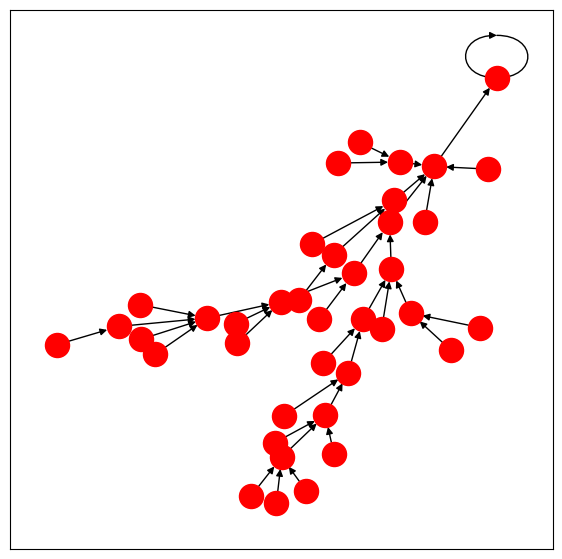

In [50]:
# let us try to visualize this mess
# we should plot this graph with labels for each node that represent
# the corresponding word in the sentence or, for simplicity, 
# the node index corresponding to that word

from torch_geometric.utils import to_networkx

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

print(tweet_list_train[1])
G = to_networkx(cv19_graph_data_train[1], to_undirected=False)
visualize_graph(G, color="red")

In [27]:
def visualize_embedding(h, labels, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    lab_dict = {0:"red", 1:"green", 2:"blue", 3:"yellow", 4:"black"}
    color = [lab_dict[elem] for elem in labels.tolist()]
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
# here we should plot some statistics about the graphs
avg_node_deg = 0

i = 0
for elem in cv19_graph_data_train:
  avg_node_deg += elem.num_edges / elem.num_nodes
  i += 1

print(f'Average node degree: {avg_node_deg:.2f}')

Average node degree: 99.00


In [ ]:
# some tests about torch methods
dim_in = 20
stride = 2
dim_out = 5
kernel_size = dim_in + stride - stride*(dim_out)
m = torch.nn.MaxPool1d(kernel_size, stride=stride)
input = torch.randn(5, dim_in)
output = m(input)
print(kernel_size)
print(input)
print(output)

16
tensor([[-1.5925,  0.0022,  0.7067, -2.0024, -1.2724,  0.1496, -1.8918,  0.6871,
         -0.4242, -0.0898,  1.4298, -0.1075,  0.9480, -0.6123, -0.4941,  0.0551,
         -1.7421,  0.4157, -0.7420,  1.4371],
        [ 1.3916,  1.5567, -0.1668,  0.1940,  0.4072, -0.0403,  0.5535,  2.0199,
          0.0459, -0.9183, -0.3440, -1.8759, -1.3917,  0.1640, -0.0533, -0.2385,
          0.2489, -0.3271,  0.0158,  0.1239],
        [ 0.6412, -0.2452,  1.1243, -0.1787, -0.2613, -0.0611, -0.0222, -1.9447,
          0.8491,  0.2514,  0.3582, -0.4173,  0.5071,  0.1291,  1.3525, -0.4849,
          0.3612,  0.6804,  1.7039, -1.0509],
        [-0.4027,  1.0090, -1.4733, -0.4079,  1.7752,  0.1531, -0.1157,  0.6521,
          0.0181,  0.1108,  0.2058, -1.8342,  1.4018, -0.9292,  0.6726, -0.3137,
         -0.4167, -0.9549, -0.9965, -1.0742],
        [-1.8269,  0.5074, -1.0205, -0.4305, -0.2979, -0.1806,  1.4340, -0.3058,
         -0.9125, -0.5650, -0.2432,  0.6846,  1.5979,  0.5021,  0.1361, -0.4148,
   

In [ ]:
# a little test about softmax and log softmax
input = torch.rand(2, 3)
print(input)
print(F.log_softmax(input, dim = 1))

tensor([[0.2001, 0.7288, 0.8339],
        [0.2603, 0.1510, 0.1969]])
tensor([[-1.5220, -0.9933, -0.8882],
        [-1.0421, -1.1514, -1.1054]])


In [ ]:
print(np.exp(0.2946)/(np.exp(0.2946) + np.exp(0.0845) + np.exp(0.1631)))

0.37212314387424467


In [29]:
batch_size = 20

# GCN definition
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h_1, dim_h_2, dim_out):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    self.gcn1 = GCNConv(dim_in, dim_h_1)
    self.gcn2 = GCNConv(dim_h_1, dim_h_2)
    self.gcn3 = GCNConv(dim_h_2, 2)
    
    self.classifier = Linear(2, dim_out)

    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3)
                                      #weight_decay=5e-5)

  def forward(self, x, edge_index, batch):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    h = self.gcn1(x, edge_index)
    h = h.tanh()
    h = self.gcn2(h, edge_index)
    h = h.tanh()
    h = self.gcn3(h, edge_index)
    h = h.tanh()
    h = global_mean_pool(h, batch)
    h = self.classifier(h)
    return h
    

# actual GAT class
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index, minibatch_size):
    #h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    #h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    h = h.transpose(0, 1)
    stride = 2
    kernel_size = x.shape[0] + stride - stride*(minibatch_size)
    m = torch.nn.MaxPool1d(kernel_size, stride=stride)
    h = m(h)
    h = h.transpose(0, 1)
    
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss() # thank god I don't have to onehot encode the labels
    optimizer = model.optimizer
    epochs = 100
    loader_train =  DataLoader(cv19_graph_data_train, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(cv19_graph_data_val, batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(epochs+1):
      for batch in loader_train:
        # Training
        end_graph_idxs = [batch[i].num_nodes for i in range(0, len(batch))]
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss_train = criterion(out, batch.y.long())
        acc_train = accuracy(out.argmax(dim=1), batch.y)
        loss_train.backward()
        optimizer.step()   
      if(epoch % 10 == 0):
        for batch in loader_val:
          out = model(batch.x, batch.edge_index, batch.batch)
          loss_val = criterion(out, batch.y.long())
          acc_val = accuracy(out.argmax(dim=1), batch.y)
          #visualize_embedding(h, batch.y, epoch, loss_val)
        print(f'Epoch {epoch:>3} | Train Loss: {loss_train:.3f} | Train Acc: '
              f'{acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {loss_val:.3f} | Val Acc: '
              f'{acc_val*100:>6.2f}%')
        
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(cv19_graph_data_train.num_node_features, 5, 5, cv19_graph_data_train.num_classes).to(device)
print(model)
data = cv19_graph_data_train.to(device)

GCN(
  (gcn1): GCNConv(768, 5)
  (gcn2): GCNConv(5, 5)
  (gcn3): GCNConv(5, 2)
  (classifier): Linear(in_features=2, out_features=5, bias=True)
)


In [35]:
trained_m = train(model)

Epoch   0 | Train Loss: 0.527 | Train Acc:  87.50%
Epoch   0 | Val Loss: 0.951 | Val Acc:  66.67%
Epoch  10 | Train Loss: 0.519 | Train Acc:  87.50%
Epoch  10 | Val Loss: 0.942 | Val Acc:  66.67%
Epoch  20 | Train Loss: 0.511 | Train Acc:  87.50%
Epoch  20 | Val Loss: 0.935 | Val Acc:  66.67%
Epoch  30 | Train Loss: 0.504 | Train Acc:  87.50%
Epoch  30 | Val Loss: 0.928 | Val Acc:  66.67%
Epoch  40 | Train Loss: 0.496 | Train Acc:  87.50%
Epoch  40 | Val Loss: 0.920 | Val Acc:  66.67%
Epoch  50 | Train Loss: 0.489 | Train Acc:  87.50%
Epoch  50 | Val Loss: 0.912 | Val Acc:  66.67%
Epoch  60 | Train Loss: 0.482 | Train Acc:  87.50%
Epoch  60 | Val Loss: 0.907 | Val Acc:  66.67%
Epoch  70 | Train Loss: 0.476 | Train Acc:  87.50%
Epoch  70 | Val Loss: 0.901 | Val Acc:  66.67%
Epoch  80 | Train Loss: 0.469 | Train Acc:  87.50%
Epoch  80 | Val Loss: 0.894 | Val Acc:  66.67%
Epoch  90 | Train Loss: 0.463 | Train Acc:  87.50%
Epoch  90 | Val Loss: 0.888 | Val Acc:  66.67%
Epoch 100 | Train Lo

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(cv19_graph_data.num_node_features, 16, cv19_graph_data.num_classes).to(device)
data = cv19_graph_data.to(device)
trained_m = train(model)

Epoch   0 | Train Loss: 1.488 | Train Acc:  40.00%
Epoch   0 | Train Loss: 2.689 | Train Acc:  30.00%
Epoch   0 | Train Loss: 2.891 | Train Acc:  30.00%
Epoch   0 | Train Loss: 3.663 | Train Acc:   0.00%
Epoch   0 | Train Loss: 1.708 | Train Acc:  21.05%
Epoch  10 | Train Loss: 2.139 | Train Acc:  20.00%
Epoch  10 | Train Loss: 1.851 | Train Acc:  35.00%
Epoch  10 | Train Loss: 1.822 | Train Acc:  40.00%
Epoch  10 | Train Loss: 1.639 | Train Acc:  15.00%
Epoch  10 | Train Loss: 1.664 | Train Acc:  21.05%
Epoch  20 | Train Loss: 1.644 | Train Acc:  25.00%
Epoch  20 | Train Loss: 1.606 | Train Acc:  25.00%
Epoch  20 | Train Loss: 1.879 | Train Acc:  10.00%
Epoch  20 | Train Loss: 1.841 | Train Acc:  20.00%
Epoch  20 | Train Loss: 2.190 | Train Acc:  10.53%
Epoch  30 | Train Loss: 1.496 | Train Acc:  25.00%
Epoch  30 | Train Loss: 1.590 | Train Acc:  35.00%
Epoch  30 | Train Loss: 1.880 | Train Acc:  15.00%
Epoch  30 | Train Loss: 1.605 | Train Acc:  25.00%
Epoch  30 | Train Loss: 1.857 |

In [ ]:
# the worst loss that we can have is:
worst_loss = - np.log(1/cv19_graph_data.num_classes)
print(worst_loss)

1.6094379124341003
